# Recommender Systems 2020/21

### Practice 5 - SLIM BPR


### State of the art machine learning algorithm

## A few info about gradient descent

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import random
from scipy import stats
from scipy.optimize import fmin

### Gradient Descent

<b>Gradient descent</b>, also known as <b>steepest descent</b>, is an optimization algorithm for finding the local minimum of a function. To find a local minimum, the function "steps" in the  direction of the negative of the gradient. <b>Gradient ascent</b> is the same as gradient descent, except that it steps in the direction of the positive of the gradient and therefore finds local maximums instead of minimums. The algorithm of gradient descent can be outlined as follows:

&nbsp;&nbsp;&nbsp; 1: &nbsp; Choose initial guess $x_0$ <br>
&nbsp;&nbsp;&nbsp;    2: &nbsp; <b>for</b> k = 0, 1, 2, ... <b>do</b> <br>
&nbsp;&nbsp;&nbsp;    3:   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $s_k$ = -$\nabla f(x_k)$ <br>
&nbsp;&nbsp;&nbsp;    4:   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; choose $\alpha_k$ to minimize $f(x_k+\alpha_k s_k)$ <br>
&nbsp;&nbsp;&nbsp;    5:   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $x_{k+1} = x_k + \alpha_k s_k$ <br>
&nbsp;&nbsp;&nbsp;    6: &nbsp;  <b>end for</b>

As a simple example, let's find a local minimum for the function $f(x) = x^3-2x^2+2$

In [2]:
f = lambda x: x**3-2*x**2+2

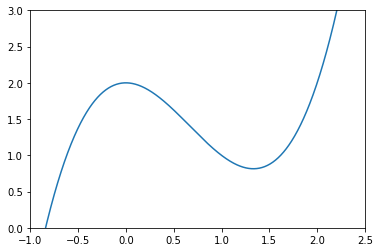

In [3]:
x = np.linspace(-1,2.5,1000)
plt.plot(x,f(x))
plt.xlim([-1,2.5])
plt.ylim([0,3])
plt.show()

We can see from plot above that our local minimum is gonna be near around 1.4 or 1.5 (on the x-axis), but let's pretend that we don't know that, so we set our starting point (arbitrarily, in this case) at $x_0 = 2$

In [4]:
x_old = 0
x_new = 2 # The algorithm starts at x=2
n_k = 0.1 # step size
precision = 0.0001

x_list, y_list = [x_new], [f(x_new)]

# returns the value of the derivative of our function
def f_gradient(x):
    return 3*x**2-4*x
 
while abs(x_new - x_old) > precision:
    
    x_old = x_new
    
    # Gradient descent step
    s_k = -f_gradient(x_old)
    
    x_new = x_old + n_k * s_k
    
    x_list.append(x_new)
    y_list.append(f(x_new))
    
print ("Local minimum occurs at: {:.2f}".format(x_new))
print ("Number of steps:", len(x_list))

Local minimum occurs at: 1.33
Number of steps: 17


The figures below show the route that was taken to find the local minimum.

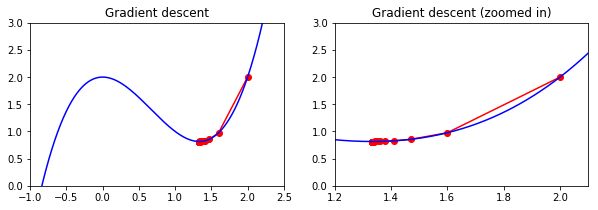

In [5]:
plt.figure(figsize=[10,3])
plt.subplot(1,2,1)
plt.scatter(x_list,y_list,c="r")
plt.plot(x_list,y_list,c="r")
plt.plot(x,f(x), c="b")
plt.xlim([-1,2.5])
plt.ylim([0,3])
plt.title("Gradient descent")
plt.subplot(1,2,2)
plt.scatter(x_list,y_list,c="r")
plt.plot(x_list,y_list,c="r")
plt.plot(x,f(x), c="b")
plt.xlim([1.2,2.1])
plt.ylim([0,3])
plt.title("Gradient descent (zoomed in)")
plt.show()

## Let's implement SLIM BPR 

In [6]:
import time
import numpy as np

### In order to implement a SLIM BPR we need to:
#### Randomly sample the triplets (user, positive_item, negative_item)
#### Compute the score of each triplet
#### Update the similarity matrix

In [7]:
from urllib.request import urlretrieve
import zipfile, os

# If file exists, skip the download
data_file_path = "data/Movielens_10M/"
data_file_name = data_file_path + "movielens_10m.zip"

# If directory does not exist, create
if not os.path.exists(data_file_path):
    os.makedirs(data_file_path)

if not os.path.exists(data_file_name):
    urlretrieve ("http://files.grouplens.org/datasets/movielens/ml-10m.zip", data_file_name)

dataFile = zipfile.ZipFile(data_file_name)
URM_path = dataFile.extract("ml-10M100K/ratings.dat", path="data/Movielens_10M")
URM_file = open(URM_path, 'r')


def rowSplit (rowString):
    
    split = rowString.split("::")
    split[3] = split[3].replace("\n","")
    
    split[0] = int(split[0])
    split[1] = int(split[1])
    split[2] = float(split[2])
    split[3] = int(split[3])
    
    result = tuple(split)
    
    return result


URM_file.seek(0)
URM_tuples = []

for line in URM_file:
   URM_tuples.append(rowSplit (line))

userList, itemList, ratingList, timestampList = zip(*URM_tuples)

userList = list(userList)
itemList = list(itemList)
ratingList = list(ratingList)
timestampList = list(timestampList)

import scipy.sparse as sps

URM_all = sps.coo_matrix((ratingList, (userList, itemList)))
URM_all = URM_all.tocsr()



from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample


URM_train, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.8)

In [8]:
URM_train = URM_train[:,0:5000]
URM_test = URM_test[:,0:5000]
URM_train

<71568x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 6769221 stored elements in Compressed Sparse Row format>

## Step 1 - Sampling

#### Create a mask of positive interactions. How to build it depends on the data

In [9]:
URM_mask = URM_train.copy()
URM_mask.data[URM_mask.data <= 3] = 0

URM_mask.eliminate_zeros()
URM_mask

<71568x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 3916039 stored elements in Compressed Sparse Row format>

In [10]:
n_users = URM_mask.shape[0]
n_items = URM_mask.shape[1]


# Extract users having at least one interaction to choose from
eligibleUsers = []

for user_id in range(n_users):

    start_pos = URM_mask.indptr[user_id]
    end_pos = URM_mask.indptr[user_id+1]

    if len(URM_mask.indices[start_pos:end_pos]) > 0:
        eligibleUsers.append(user_id)
                
                

def sampleTriplet():
    
    # By randomly selecting a user in this way we could end up 
    # with a user with no interactions
    #user_id = np.random.randint(0, n_users)
    
    user_id = np.random.choice(eligibleUsers)
    
    # Get user seen items and choose one
    userSeenItems = URM_mask[user_id,:].indices
    pos_item_id = np.random.choice(userSeenItems)

    negItemSelected = False

    # It's faster to just try again then to build a mapping of the non-seen items
    while (not negItemSelected):
        neg_item_id = np.random.randint(0, n_items)

        if (neg_item_id not in userSeenItems):
            
            negItemSelected = True

    return user_id, pos_item_id, neg_item_id


In [11]:
for _ in range(10):
    print(sampleTriplet())

(8288, 105, 1630)
(2982, 1094, 3317)
(26453, 653, 358)
(11989, 1148, 1244)
(55371, 3358, 3572)
(33429, 3996, 1101)
(55792, 50, 3366)
(57923, 2081, 2453)
(26150, 498, 1001)
(38236, 110, 1682)


## Step 2 - Computing prediction

#### The prediction depends on the model: SLIM, Matrix Factorization... 

### We have to initialize our model. In case of SLIM it works best to initialize S as zero, in case of MF you cannot because of how the gradient is computed and you have to initialize at random. Here we initialize SLIM at random just so that we have some numbers to show

In [12]:
#similarity_matrix = np.zeros((n_items,n_items))

similarity_matrix = np.random.random((n_items,n_items))
similarity_matrix[np.arange(n_items),np.arange(n_items)] = 0

In [13]:
user_id, positive_item_id, negative_item_id = sampleTriplet()

In [14]:
positive_item_id

372

In [15]:
negative_item_id

933

In [16]:
userSeenItems = URM_mask[user_id,:].indices
userSeenItems

array([  22,   32,  110,  372,  380,  441,  593,  608,  858, 1042, 1193,
       1513, 1721, 1747, 2144, 2268, 2762, 2858, 2959, 3863, 4865, 4963])

In [17]:
x_i = similarity_matrix[positive_item_id, userSeenItems].sum()
x_j = similarity_matrix[negative_item_id, userSeenItems].sum()

print("x_i is {:.2f}, x_j is {:.2f}".format(x_i, x_j))

x_i is 10.36, x_j is 9.61


## Step 3 - Computing gradient

#### The gradient depends on the objective function: RMSE, BPR... 

In [18]:
x_ij = x_i - x_j
x_ij

0.7458571825185416

#### The original BPR paper uses the logarithm of the sigmoid of x_ij, whose derivative is the following

In [19]:
gradient = 1 / (1 + np.exp(x_ij))
gradient

0.32172466929646293

## Step 4 - Update model

#### How to update depends on the model itself, here we have just one paramether, the similarity matrix, so we perform just one update. In matrix factorization we have two.

#### We need a learning rate, which influences how fast the model will change. Small ones lead to slower convergence but often higher results

In [20]:
learning_rate = 1e-3

similarity_matrix[positive_item_id, userSeenItems] += learning_rate * gradient
similarity_matrix[positive_item_id, positive_item_id] = 0

similarity_matrix[negative_item_id, userSeenItems] -= learning_rate * gradient
similarity_matrix[negative_item_id, negative_item_id] = 0

#### Usually there is no relevant change in the scores over a single iteration

In [21]:
x_i = similarity_matrix[positive_item_id, userSeenItems].sum()
x_j = similarity_matrix[negative_item_id, userSeenItems].sum()

print("x_i is {:.2f}, x_j is {:.2f}".format(x_i, x_j))

x_i is 10.37, x_j is 9.61


## Step 5 - Write the iterative epochs

In [22]:
import time

def epochIteration():

    # Get number of available interactions
    numPositiveIteractions = int(URM_mask.nnz*0.01)

    start_time_epoch = time.time()
    start_time_batch = time.time()

    # Uniform user sampling without replacement
    for num_sample in range(numPositiveIteractions):

        # Sample
        user_id, positive_item_id, negative_item_id = sampleTriplet()
        
        userSeenItems = URM_mask[user_id,:].indices
        
        # Prediction
        x_i = similarity_matrix[positive_item_id, userSeenItems].sum()
        x_j = similarity_matrix[negative_item_id, userSeenItems].sum()
        
        # Gradient
        x_ij = x_i - x_j

        gradient = 1 / (1 + np.exp(x_ij))
        
        # Update
        similarity_matrix[positive_item_id, userSeenItems] += learning_rate * gradient
        similarity_matrix[positive_item_id, positive_item_id] = 0

        similarity_matrix[negative_item_id, userSeenItems] -= learning_rate * gradient
        similarity_matrix[negative_item_id, negative_item_id] = 0
        

        if(time.time() - start_time_batch >= 30 or num_sample == numPositiveIteractions-1):
            print("Processed {} ( {:.2f}% ) in {:.2f} seconds. Sample per second: {:.0f}".format(
                num_sample,
                100.0* float(num_sample)/numPositiveIteractions,
                time.time() - start_time_batch,
                float(num_sample) / (time.time() - start_time_epoch)))


            start_time_batch = time.time()


In [23]:
epochIteration()

Processed 5378 ( 13.73% ) in 30.01 seconds. Sample per second: 179
Processed 10458 ( 26.71% ) in 30.01 seconds. Sample per second: 174
Processed 16640 ( 42.49% ) in 30.00 seconds. Sample per second: 185
Processed 22990 ( 58.71% ) in 30.00 seconds. Sample per second: 192
Processed 28602 ( 73.04% ) in 30.01 seconds. Sample per second: 191
Processed 33604 ( 85.81% ) in 30.01 seconds. Sample per second: 187
Processed 38721 ( 98.88% ) in 30.01 seconds. Sample per second: 184
Processed 39159 ( 100.00% ) in 2.33 seconds. Sample per second: 184


In [24]:
import scipy.sparse as sps


def similarityMatrixTopK(item_weights, forceSparseOutput = True, k=100, verbose = False, inplace=True):
    """
    The function selects the TopK most similar elements, column-wise

    :param item_weights:
    :param forceSparseOutput:
    :param k:
    :param verbose:
    :param inplace: Default True, WARNING matrix will be modified
    :return:
    """

    assert (item_weights.shape[0] == item_weights.shape[1]), "selectTopK: ItemWeights is not a square matrix"

    start_time = time.time()

    if verbose:
        print("Generating topK matrix")

    nitems = item_weights.shape[1]
    k = min(k, nitems)

    # for each column, keep only the top-k scored items
    sparse_weights = not isinstance(item_weights, np.ndarray)

    if not sparse_weights:

        idx_sorted = np.argsort(item_weights, axis=0)  # sort data inside each column

        if inplace:
            W = item_weights
        else:
            W = item_weights.copy()

        # index of the items that don't belong to the top-k similar items of each column
        not_top_k = idx_sorted[:-k, :]
        # use numpy fancy indexing to zero-out the values in sim without using a for loop
        W[not_top_k, np.arange(nitems)] = 0.0

        if forceSparseOutput:
            W_sparse = sps.csr_matrix(W, shape=(nitems, nitems))

            if verbose:
                print("Sparse TopK matrix generated in {:.2f} seconds".format(time.time() - start_time))

            return W_sparse

        if verbose:
            print("Dense TopK matrix generated in {:.2f} seconds".format(time.time()-start_time))

        return W

    else:
        # iterate over each column and keep only the top-k similar items
        data, rows_indices, cols_indptr = [], [], []

        item_weights = check_matrix(item_weights, format='csc', dtype=np.float32)

        for item_idx in range(nitems):

            cols_indptr.append(len(data))

            start_position = item_weights.indptr[item_idx]
            end_position = item_weights.indptr[item_idx+1]

            column_data = item_weights.data[start_position:end_position]
            column_row_index = item_weights.indices[start_position:end_position]

            non_zero_data = column_data!=0

            idx_sorted = np.argsort(column_data[non_zero_data])  # sort by column
            top_k_idx = idx_sorted[-k:]

            data.extend(column_data[non_zero_data][top_k_idx])
            rows_indices.extend(column_row_index[non_zero_data][top_k_idx])


        cols_indptr.append(len(data))

        # During testing CSR is faster
        W_sparse = sps.csc_matrix((data, rows_indices, cols_indptr), shape=(nitems, nitems), dtype=np.float32)
        W_sparse = W_sparse.tocsr()

        if verbose:
            print("Sparse TopK matrix generated in {:.2f} seconds".format(time.time() - start_time))

        return W_sparse



In [25]:
class SLIM_BPR_Recommender(object):
    """ SLIM_BPR recommender with cosine similarity and no shrinkage"""

    def __init__(self, URM):
        self.URM = URM
        
        self.similarity_matrix = np.zeros((n_items,n_items))
        
        self.URM_mask = self.URM.copy()
        self.URM_mask.data[self.URM_mask.data <= 3] = 0
        self.URM_mask.eliminate_zeros()
        
        self.n_users = URM_mask.shape[0]
        self.n_items = URM_mask.shape[1]


        # Extract users having at least one interaction to choose from
        self.eligibleUsers = []

        for user_id in range(n_users):

            start_pos = self.URM_mask.indptr[user_id]
            end_pos = self.URM_mask.indptr[user_id+1]

            if len(self.URM_mask.indices[start_pos:end_pos]) > 0:
                self.eligibleUsers.append(user_id)



    def sampleTriplet(self):

        # By randomly selecting a user in this way we could end up 
        # with a user with no interactions
        #user_id = np.random.randint(0, n_users)

        user_id = np.random.choice(self.eligibleUsers)

        # Get user seen items and choose one
        userSeenItems = URM_mask[user_id,:].indices
        pos_item_id = np.random.choice(userSeenItems)

        negItemSelected = False

        # It's faster to just try again then to build a mapping of the non-seen items
        while (not negItemSelected):
            neg_item_id = np.random.randint(0, n_items)

            if (neg_item_id not in userSeenItems):

                negItemSelected = True

        return user_id, pos_item_id, neg_item_id


        
    def epochIteration(self):

        # Get number of available interactions
        numPositiveIteractions = int(self.URM_mask.nnz*0.01)

        start_time_epoch = time.time()
        start_time_batch = time.time()

        # Uniform user sampling without replacement
        for num_sample in range(numPositiveIteractions):

            # Sample
            user_id, positive_item_id, negative_item_id = self.sampleTriplet()

            userSeenItems = self.URM_mask[user_id,:].indices

            # Prediction
            x_i = self.similarity_matrix[positive_item_id, userSeenItems].sum()
            x_j = self.similarity_matrix[negative_item_id, userSeenItems].sum()

            # Gradient
            x_ij = x_i - x_j

            gradient = 1 / (1 + np.exp(x_ij))

            # Update
            self.similarity_matrix[positive_item_id, userSeenItems] += learning_rate * gradient
            self.similarity_matrix[positive_item_id, positive_item_id] = 0

            self.similarity_matrix[negative_item_id, userSeenItems] -= learning_rate * gradient
            self.similarity_matrix[negative_item_id, negative_item_id] = 0


            if(time.time() - start_time_batch >= 30 or num_sample == numPositiveIteractions-1):
                print("Processed {} ( {:.2f}% ) in {:.2f} seconds. Sample per second: {:.0f}".format(
                    num_sample,
                    100.0* float(num_sample)/numPositiveIteractions,
                    time.time() - start_time_batch,
                    float(num_sample) / (time.time() - start_time_epoch)))

                start_time_batch = time.time()

                
    def fit(self, learning_rate = 0.01, epochs = 10):
 
        self.learning_rate = learning_rate
        self.epochs = epochs

        for numEpoch in range(self.epochs):
            self.epochIteration()
            
        self.similarity_matrix = self.similarity_matrix.T
        
        self.similarity_matrix = similarityMatrixTopK(self.similarity_matrix, k=100)
        
        
        
    def recommend(self, user_id, at=None, exclude_seen=True):
        # compute the scores using the dot product
        user_profile = self.URM[user_id]
        scores = user_profile.dot(self.similarity_matrix).toarray().ravel()

        if exclude_seen:
            scores = self.filter_seen(user_id, scores)

        # rank items
        ranking = scores.argsort()[::-1]
            
        return ranking[:at]
    
    
    def filter_seen(self, user_id, scores):

        start_pos = self.URM.indptr[user_id]
        end_pos = self.URM.indptr[user_id+1]

        user_profile = self.URM.indices[start_pos:end_pos]
        
        scores[user_profile] = -np.inf

        return scores  
    

In [26]:
recommender = SLIM_BPR_Recommender(URM_train)
recommender.fit(epochs=1)

Processed 5494 ( 14.03% ) in 30.01 seconds. Sample per second: 183
Processed 11473 ( 29.30% ) in 30.01 seconds. Sample per second: 191
Processed 17290 ( 44.15% ) in 30.02 seconds. Sample per second: 192
Processed 23027 ( 58.80% ) in 30.01 seconds. Sample per second: 192
Processed 28604 ( 73.04% ) in 30.01 seconds. Sample per second: 191
Processed 33575 ( 85.74% ) in 30.01 seconds. Sample per second: 186
Processed 38543 ( 98.42% ) in 30.01 seconds. Sample per second: 183
Processed 39159 ( 100.00% ) in 3.91 seconds. Sample per second: 183


In [27]:
from Notebooks_utils.evaluation_function import evaluate_algorithm

evaluate_algorithm(URM_test, recommender)

Evaluated user 0 of 71568
Evaluated user 10000 of 71568
Evaluated user 20000 of 71568
Evaluated user 30000 of 71568
Evaluated user 40000 of 71568
Evaluated user 50000 of 71568
Evaluated user 60000 of 71568
Evaluated user 70000 of 71568
Recommender performance is: Precision = 0.2621, Recall = 0.0896, MAP = 0.1989


{'precision': 0.26210298398320586,
 'recall': 0.08955017906833086,
 'MAP': 0.19894397921779672}

### Reasonable performance
#### Note that we ran just one epoch on a micro-subsample of the data. Being a machine learning approach, more time is needed

### Let's load the cython impementation and run some serious learning. Here I show just two epochs

In [29]:
from SLIM_BPR.Cython.SLIM_BPR_Cython import SLIM_BPR_Cython



recommender = SLIM_BPR_Cython(URM_train, recompile_cython=False)

recommender.fit(epochs=2, batch_size=1, sgd_mode='sgd', learning_rate=1e-4, positive_threshold_BPR=4)
 
    


SLIM_BPR_Recommender: URM Detected 1692 (2.36 %) cold users.
SLIM_BPR_Recommender: URM Detected 96 (1.92 %) cold items.
Unable to read memory status: list index out of range
SLIM_BPR_Recommender: Automatic selection of fastest train mode. Unable to get current RAM status, you may be using a non-Linux operating system. Using dense matrix.
Processed 71568 ( 100.00% ) in 0.68 seconds. BPR loss is 2.16E-03. Sample per second: 105931
SLIM_BPR_Recommender: Epoch 1 of 2. Elapsed time 0.45 sec
Processed 71568 ( 100.00% ) in 1.13 seconds. BPR loss is 1.37E-02. Sample per second: 63589
SLIM_BPR_Recommender: Epoch 2 of 2. Elapsed time 0.90 sec
SLIM_BPR_Recommender: Terminating at epoch 2. Elapsed time 2.05 sec
Deallocating Cython objects


In [30]:
from Base.Evaluation.Evaluator import EvaluatorHoldout

evaluator_validation = EvaluatorHoldout(URM_test, cutoff_list=[5])


evaluator_validation.evaluateRecommender(recommender)

EvaluatorHoldout: Processed 59510 ( 85.33% ) in 30.02 sec. Users per second: 1983
EvaluatorHoldout: Processed 69739 ( 100.00% ) in 36.05 sec. Users per second: 1934


({5: {'ROC_AUC': 0.37906933948961963,
   'PRECISION': 0.2629948809131884,
   'PRECISION_RECALL_MIN_DEN': 0.2686786924581338,
   'RECALL': 0.08816346989303116,
   'MAP': 0.19634895825869142,
   'MRR': 0.43688753781957185,
   'NDCG': 0.139975255418048,
   'F1': 0.1320574675907752,
   'HIT_RATE': 1.3149744045655947,
   'ARHR': 0.6473783201173414,
   'RMSE': 3.351348491785974,
   'NOVELTY': 0.008235469902706695,
   'AVERAGE_POPULARITY': 0.8221555650858704,
   'DIVERSITY_MEAN_INTER_LIST': 0.6993780325105289,
   'DIVERSITY_HERFINDAHL': 0.939873600800755,
   'COVERAGE_ITEM': 0.0786,
   'COVERAGE_USER': 0.9744438855354348,
   'DIVERSITY_GINI': 0.0483961992295712,
   'SHANNON_ENTROPY': 4.566429947440342}},
 'CUTOFF: 5 - ROC_AUC: 0.3790693, PRECISION: 0.2629949, PRECISION_RECALL_MIN_DEN: 0.2686787, RECALL: 0.0881635, MAP: 0.1963490, MRR: 0.4368875, NDCG: 0.1399753, F1: 0.1320575, HIT_RATE: 1.3149744, ARHR: 0.6473783, RMSE: 3.3513485, NOVELTY: 0.0082355, AVERAGE_POPULARITY: 0.8221556, DIVERSITY_M

#### Compared to content and collaborative k-nearest neighbor SLIM improves map significantly (on this dataset)

### Common mistakes in using ML (based on last year's presentations)

* Use default parameters and then give up when results are not good
* Train for just 1 or 2 epochs
* Use huge learning rate or regularization parameters: 1, 50, 100

## Let's now move to SLIM ElasticNet 

#### ElasticNet optimizes prediction error and l1, l2 norms over the similarity matrix to ensure sparsity and counter overfitting

### Key idea:
##### Learn every item similarity column independently, in such a way that those similarities will allow the model to predict the interaction score (rating) for that item using all other item iteractions.

In [31]:

import numpy as np
import scipy.sparse as sps

from sklearn.linear_model import ElasticNet

import time, sys





class SLIMElasticNetRecommender(object):
    """
    Train a Sparse Linear Methods (SLIM) item similarity model.
    NOTE: ElasticNet solver is parallel, a single intance of SLIM_ElasticNet will
          make use of half the cores available

    See:
        Efficient Top-N Recommendation by Linear Regression,
        M. Levy and K. Jack, LSRS workshop at RecSys 2013.
        https://www.slideshare.net/MarkLevy/efficient-slides

        SLIM: Sparse linear methods for top-n recommender systems,
        X. Ning and G. Karypis, ICDM 2011.
        http://glaros.dtc.umn.edu/gkhome/fetch/papers/SLIM2011icdm.pdf
    """

    RECOMMENDER_NAME = "SLIMElasticNetRecommender"

    def __init__(self, URM_train):

        super(SLIMElasticNetRecommender, self).__init__()

        self.URM_train = URM_train


    def fit(self, l1_penalty=0.1, l2_penalty=0.1, positive_only=True, topK = 100):

        self.l1_penalty = l1_penalty
        self.l2_penalty = l2_penalty
        self.positive_only = positive_only
        self.topK = topK

        if self.l1_penalty + self.l2_penalty != 0:
            self.l1_ratio = self.l1_penalty / (self.l1_penalty + self.l2_penalty)
        else:
            print("SLIM_ElasticNet: l1_penalty+l2_penalty cannot be equal to zero, setting the ratio l1/(l1+l2) to 1.0")
            self.l1_ratio = 1.0



        # initialize the ElasticNet model
        self.model = ElasticNet(alpha=1.0,
                                l1_ratio=self.l1_ratio,
                                positive=self.positive_only,
                                fit_intercept=False,
                                copy_X=False,
                                precompute=True,
                                selection='random',
                                max_iter=100,
                                tol=1e-4)


        URM_train = sps.csc_matrix(self.URM_train)

        n_items = URM_train.shape[1]


        # Use array as it reduces memory requirements compared to lists
        dataBlock = 10000000

        rows = np.zeros(dataBlock, dtype=np.int32)
        cols = np.zeros(dataBlock, dtype=np.int32)
        values = np.zeros(dataBlock, dtype=np.float32)

        numCells = 0


        start_time = time.time()
        start_time_printBatch = start_time

        # fit each item's factors sequentially (not in parallel)
        for currentItem in range(n_items):

            # get the target column
            y = URM_train[:, currentItem].toarray()

            # set the j-th column of X to zero
            start_pos = URM_train.indptr[currentItem]
            end_pos = URM_train.indptr[currentItem + 1]

            current_item_data_backup = URM_train.data[start_pos: end_pos].copy()
            URM_train.data[start_pos: end_pos] = 0.0



            # fit one ElasticNet model per column
            self.model.fit(URM_train, y)

            # self.model.coef_ contains the coefficient of the ElasticNet model
            # let's keep only the non-zero values

            # Select topK values
            # Sorting is done in three steps. Faster then plain np.argsort for higher number of items
            # - Partition the data to extract the set of relevant items
            # - Sort only the relevant items
            # - Get the original item index

            nonzero_model_coef_index = self.model.sparse_coef_.indices
            nonzero_model_coef_value = self.model.sparse_coef_.data


            local_topK = min(len(nonzero_model_coef_value)-1, self.topK)

            relevant_items_partition = (-nonzero_model_coef_value).argpartition(local_topK)[0:local_topK]
            relevant_items_partition_sorting = np.argsort(-nonzero_model_coef_value[relevant_items_partition])
            ranking = relevant_items_partition[relevant_items_partition_sorting]


            for index in range(len(ranking)):

                if numCells == len(rows):
                    rows = np.concatenate((rows, np.zeros(dataBlock, dtype=np.int32)))
                    cols = np.concatenate((cols, np.zeros(dataBlock, dtype=np.int32)))
                    values = np.concatenate((values, np.zeros(dataBlock, dtype=np.float32)))


                rows[numCells] = nonzero_model_coef_index[ranking[index]]
                cols[numCells] = currentItem
                values[numCells] = nonzero_model_coef_value[ranking[index]]

                numCells += 1


            # finally, replace the original values of the j-th column
            URM_train.data[start_pos:end_pos] = current_item_data_backup


            if time.time() - start_time_printBatch > 300 or currentItem == n_items-1:
                print("Processed {} ( {:.2f}% ) in {:.2f} minutes. Items per second: {:.0f}".format(
                                  currentItem+1,
                                  100.0* float(currentItem+1)/n_items,
                                  (time.time()-start_time)/60,
                                  float(currentItem)/(time.time()-start_time)))
                sys.stdout.flush()
                sys.stderr.flush()

                start_time_printBatch = time.time()


        # generate the sparse weight matrix
        self.W_sparse = sps.csr_matrix((values[:numCells], (rows[:numCells], cols[:numCells])),
                                       shape=(n_items, n_items), dtype=np.float32)




        
    def recommend(self, user_id, at=None, exclude_seen=True):
        # compute the scores using the dot product
        user_profile = self.URM_train[user_id]
        scores = user_profile.dot(self.W_sparse).toarray().ravel()

        if exclude_seen:
            scores = self.filter_seen(user_id, scores)

        # rank items
        ranking = scores.argsort()[::-1]
            
        return ranking[:at]
    
    
    def filter_seen(self, user_id, scores):

        start_pos = self.URM_train.indptr[user_id]
        end_pos = self.URM_train.indptr[user_id+1]

        user_profile = self.URM_train.indices[start_pos:end_pos]
        
        scores[user_profile] = -np.inf

        return scores  
    

In [32]:
recommender = SLIMElasticNetRecommender(URM_train)

recommender.fit()


Deallocating Cython objects
Processed 599 ( 11.98% ) in 5.00 minutes. Items per second: 2
Processed 1141 ( 22.82% ) in 10.00 minutes. Items per second: 2
Processed 1537 ( 30.74% ) in 15.01 minutes. Items per second: 2
Processed 1842 ( 36.84% ) in 20.01 minutes. Items per second: 2
Processed 2198 ( 43.96% ) in 25.02 minutes. Items per second: 1
Processed 2588 ( 51.76% ) in 30.03 minutes. Items per second: 1
Processed 2960 ( 59.20% ) in 35.04 minutes. Items per second: 1
Processed 3340 ( 66.80% ) in 40.05 minutes. Items per second: 1
Processed 3726 ( 74.52% ) in 45.05 minutes. Items per second: 1
Processed 4074 ( 81.48% ) in 50.06 minutes. Items per second: 1
Processed 4445 ( 88.90% ) in 55.06 minutes. Items per second: 1
Processed 4913 ( 98.26% ) in 60.07 minutes. Items per second: 1
Processed 5000 ( 100.00% ) in 60.64 minutes. Items per second: 1


In [33]:
evaluate_algorithm(URM_test, recommender)

Evaluated user 0 of 71568
Evaluated user 10000 of 71568
Evaluated user 20000 of 71568
Evaluated user 30000 of 71568
Evaluated user 40000 of 71568
Evaluated user 50000 of 71568
Evaluated user 60000 of 71568
Evaluated user 70000 of 71568
Recommender performance is: Precision = 0.3303, Recall = 0.1133, MAP = 0.2641


{'precision': 0.3302657049858151,
 'recall': 0.11332678222135233,
 'MAP': 0.2640531561329721}

#### As opposed to SLIM BPR, ElasticNet has some advantages, namely it relies upon a parallel solver and works on all OS, whyle Cython is sequetial and needs to be compiled or adapted. It has however disadvantages like a VERY slow training on some datasets.